In [2]:
import numpy as np
import pandas as pd
import mysql.connector

# Connect to the MySQL database
db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Vishrut@123',
    database='ecommerce'
)
cursor = db.cursor()

# List all unique cities where customers are located


In [9]:
query = """select distinct customer_city from customers"""

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data)
df

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# Count the number of orders placed in 2017.

In [11]:
query = """select count(order_id) from orders where year(order_purchase_timestamp)=2017"""
cursor.execute(query)
data = cursor.fetchall()
'Total orders placed in 2017 are: ', data[0][0]

('Total orders placed in 2017 are: ', 45101)

# Find the total sales per category.

In [5]:
query= """SELECT 
    products.product_category AS category,
    round(SUM(payments.payment_value),2) AS total_sales
FROM 
    products
JOIN 
    order_items ON products.product_id = order_items.product_id
JOIN 
    payments ON order_items.order_id = payments.order_id
GROUP BY 
    products.product_category;"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data)
df.head(20)

,0,1
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,Fashion Bags and Accessories,218158.28
4,bed table bath,1712553.67
5,automotive,852294.33
6,computer accessories,1585330.45
7,housewares,1094758.13
8,babies,539845.66
9,toys,619037.69


# Calculate the percentage of orders that were paid in installments.

In [31]:
query = """ select ((sum(case when payment_installments >= 1 then 1
else 0 end))/count(*))*100 from payments
"""
cursor.execute(query)
data = cursor.fetchall()

data[0][0]

Decimal('99.9981')

# Count the number of customers from each state. 

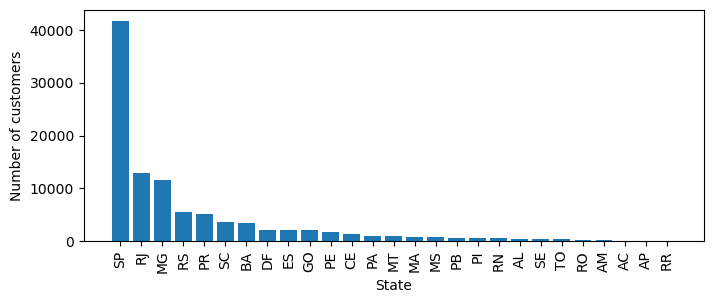

In [50]:
import matplotlib.pyplot as plt
query = """select customer_state , count(customer_id) from customers group by customer_state"""
cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns=['Customer_state','Number of customers'])
df = df.sort_values(by = "Number of customers", ascending= False)
plt.figure(figsize = (8,3))
plt.bar(df['Customer_state'],df['Number of customers'])
plt.xticks(rotation = 90)
plt.xlabel('State')
plt.ylabel('Number of customers')
plt.show()

# Calculate the number of orders per month in 2018

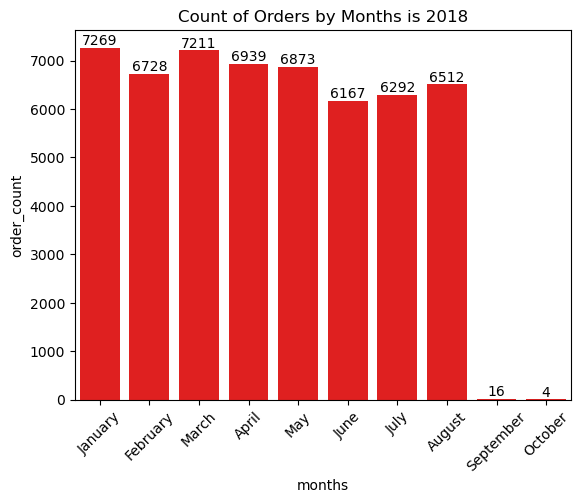

In [49]:
import seaborn as sns
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cursor.execute(query)

data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"],y =  df["order_count"],data = df,  order = o, color = "red")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

# Find the average number of products per order, grouped by customer city.

In [10]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city , avg(count_per_order.oc) average_orders
from customers 
join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
order by average_orders asc
"""

cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns= ['Customer_city','average products_per_order'])
df

,Customer_city,average products_per_order
0,santo antonio do planalto,1.0000
1,amapa do maranhao,1.0000
2,atilio vivacqua,1.0000
3,carnauba dos dantas,1.0000
4,terra nova,1.0000
...,...,...
4105,matias olimpio,5.0000
4106,candido godoi,6.0000
4107,datas,6.0000
4108,celso ramos,6.5000


# Calculate the percentage of total revenue contributed by each product category.

In [11]:
query = """
    select upper(products.product_category) ,round( sum(payments.payment_value)/(select sum(payment_value) from payments)*100 ,2)
    from products
    join order_items
    on products.product_id = order_items.product_id
    join payments 
    on order_items.order_id = payments.order_id
    group by products.product_category 
    
"""

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data)
df.head(20)

,0,1
0,PERFUMERY,3.17
1,FURNITURE DECORATION,8.93
2,TELEPHONY,3.04
3,FASHION BAGS AND ACCESSORIES,1.36
4,BED TABLE BATH,10.70
5,AUTOMOTIVE,5.32
6,COMPUTER ACCESSORIES,9.90
7,HOUSEWARES,6.84
8,BABIES,3.37
9,TOYS,3.87


# Identify the correlation between product price and the number of times a product has been purchased.

In [70]:
query = """
    select products.product_category, 
        count(order_items.product_id) Count_product,
        round(avg(order_items.price),2) Average_price
    from products 
    join order_items
    on products.product_id = order_items.product_id
    group by products.product_category
"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ['Category','Count_product','Average_price'])

arr1 = df["Count_product"]
arr2 = df["Average_price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.


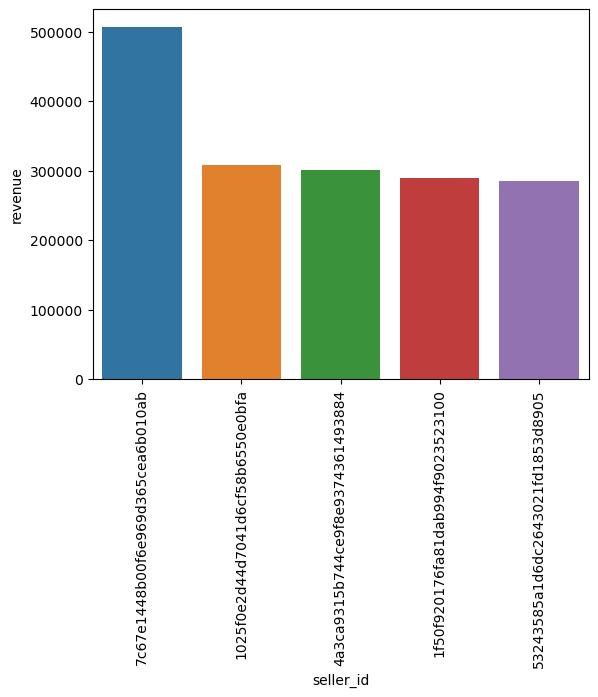

In [86]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select sellers.seller_id , round(sum(payments.payment_value),2) as revenue
from sellers
join order_items
on sellers.seller_id = order_items.seller_id
join payments
on order_items.order_id = payments.order_id
group by sellers.seller_id) as a """

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

In [8]:
query = """select customer_id , order_purchase_timestamp,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
	rows between 2 preceding and current row) as m
from    
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""

cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data,columns = ['Customer_id','Order_timestamp','Moving_avg'])
df

,Customer_id,Order_timestamp,Moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.010002
...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.500000
